# Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pkg_resources
import types

#SKLearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, TimeSeriesSplit
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, plot_roc_curve, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans ,AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# mlxtend
from mlxtend.plotting import plot_decision_regions

#Yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.features.pca import PCADecomposition

# lightgbm
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

# XGBoost
from xgboost import XGBClassifier

C:\Users\julia\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Exploratory Data Analysis

Setting config to always display all columns:

In [4]:
pd.options.display.max_columns = None

Reading dataset:

In [6]:
rain = pd.read_csv('./data/rain_data_aus.csv')

In [7]:
rain.shape

(142193, 23)

In [8]:
rain.head()

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,amountOfRain,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No,29.48,28.400000,12,5.115360,0.089825
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No,32.12,2.208569,10,21.497100,0.023477
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No,32.84,38.000000,17,20.782859,0.027580
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No,35.60,21.200000,8,12.028646,0.023962
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No,40.76,41.600000,9,11.883546,0.220164


There are 4 object columns: 

In [9]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
date                142193 non-null object
location            142193 non-null object
mintemp             141556 non-null float64
maxtemp             141871 non-null float64
rainfall            140787 non-null float64
evaporation         81350 non-null float64
sunshine            74377 non-null float64
humidity9am         140419 non-null float64
humidity3pm         138583 non-null float64
pressure9am         128179 non-null float64
pressure3pm         128212 non-null float64
cloud9am            88536 non-null float64
cloud3pm            85099 non-null float64
temp9am             141289 non-null float64
temp3pm             139467 non-null float64
raintoday           140787 non-null object
amountOfRain        142193 non-null float64
raintomorrow        142193 non-null object
temp                141871 non-null float64
humidity            138583 non-null float64
precipitation3pm 

Looking for missing values

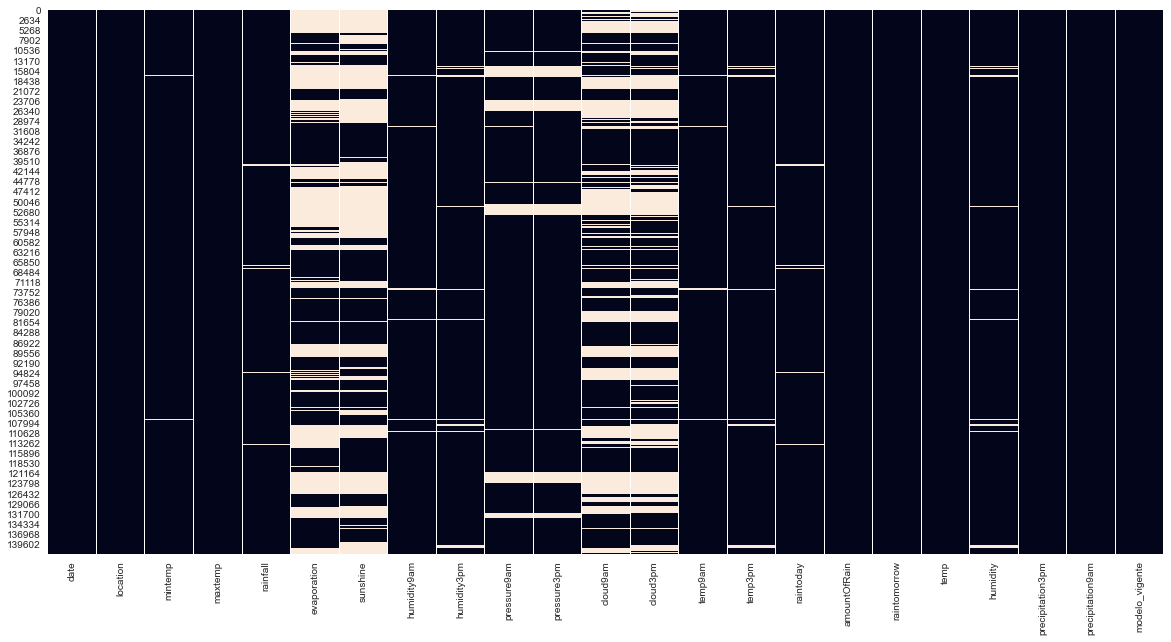

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(rain.isnull(), cbar=False);

In [11]:
rain.select_dtypes(include='object').columns

Index(['date', 'location', 'raintoday', 'raintomorrow'], dtype='object')

In [12]:
rain.isnull().sum()

date                    0
location                0
mintemp               637
maxtemp               322
rainfall             1406
evaporation         60843
sunshine            67816
humidity9am          1774
humidity3pm          3610
pressure9am         14014
pressure3pm         13981
cloud9am            53657
cloud3pm            57094
temp9am               904
temp3pm              2726
raintoday            1406
amountOfRain            0
raintomorrow            0
temp                  322
humidity             3610
precipitation3pm        0
precipitation9am        0
modelo_vigente          0
dtype: int64

# Simple Baseline

Create a simple logistic regression baseline

## Treating missing values

Droping columns with high missing values:
more than 1/3 of missing values

In [14]:
nan = rain.isnull().sum()
cols_to_drop = []

for i, value in enumerate(nan.values):
    if value > rain.shape[0]/3:
        cols_to_drop.append(nan.index[i])
        
cols_to_drop

['evaporation', 'sunshine', 'cloud9am', 'cloud3pm']

In [15]:
rain = rain.drop(cols_to_drop, axis=1)

In [16]:
rain.shape

(142193, 19)

We also decided to drop 'pressure9am' and 'pressure3pm' columns for now

In [17]:
#Almost 10% of null values
rain['pressure9am'].isnull().value_counts(normalize=True)

False    0.901444
True     0.098556
Name: pressure9am, dtype: float64

In [18]:
#Almost 10% of null values too
rain['pressure3pm'].isnull().value_counts(normalize=True)

False    0.901676
True     0.098324
Name: pressure3pm, dtype: float64

Grouping by location we can see that some cities do not record the values of these features. Despite the possible relevance of these features, we decided to drop the columns to make a baseline and later we will check these columns. We chose to drop the columns instead of the rows because by dropping the rows we could lose all values for those cities.

In [19]:
rain.groupby(by= 'location')[['pressure9am', 'pressure3pm']].describe()

pressure9am                                                   \
                       count         mean       std    min       25%      50%   
location                                                                        
Adelaide              3082.0  1018.727579  7.357987  982.3  1013.700  1018.70   
Albany                2991.0  1018.283049  7.251447  989.2  1013.600  1018.50   
Albury                3011.0  1018.367253  7.361457  989.8  1013.400  1018.40   
AliceSprings          3030.0  1016.699670  6.409189  997.7  1011.725  1016.70   
BadgerysCreek         2785.0  1018.450880  7.014221  996.8  1013.900  1018.60   
Ballarat              3004.0  1017.855293  7.611270  989.4  1012.900  1017.90   
Bendigo               3020.0  1018.024272  7.448458  989.5  1013.000  1018.10   
Brisbane              3161.0  1018.246947  5.461651  997.8  1014.600  1018.30   
Cairns                2988.0  1014.154284  4.183403  994.4  1011.400  1014.70   
Canberra              3194.0  1018.986725  7.492871  987.4  1013.925  1018.90   
Cobar                 2961.0  1017.995137  6.462880  991.7  1013.300  1017.90   
CoffsHarbour          2688.0  1018.222731  6.076822  998.3  1014.100  1018.30   
Dartmoor              2942.0  1017.997621  7.962654  986.2  1012.800  1018.20   
Darwin                3191.0  1011.888154  3.355192  996.3  1009.600  1012.20   
GoldCoast             2980.0  1017.932081  5.457297  999.5  1014.200  1017.90   
Hobart                3187.0  1014.526828  9.964205  982.2  1008.200  1015.40   
Katherine             1558.0  1012.840244  3.797706  998.9  1010.125  1013.00   
Launceston            1882.0  1015.666578  9.238052  985.0  1009.900  1016.35   
Melbourne             2434.0  1017.732580  7.834652  988.9  1012.625  1018.00   
MelbourneAirport      3009.0  1018.087670  7.682523  989.7  1013.100  1018.30   
Mildura               3003.0  1018.771029  7.053044  991.3  1013.900  1018.70   
Moree                 2854.0  1018.309706  5.952067  999.0  1014.000  1018.30   
MountGambier          3029.0  1017.940112  7.934820  985.1  1012.800  1018.20   
MountGinini              0.0          NaN       NaN    NaN       NaN      NaN   
Newcastle                0.0          NaN       NaN    NaN       NaN      NaN   
Nhil                  1569.0  1018.546335  7.543523  986.9  1013.500  1018.50   
NorahHead             2917.0  1018.259033  6.732356  996.5  1013.900  1018.30   
NorfolkIsland         2956.0  1017.631360  5.510219  980.5  1014.200  1018.00   
Nuriootpa             2995.0  1018.915793  7.154657  982.0  1014.100  1018.80   
PearceRAAF            2744.0  1017.746902  6.311765  996.9  1013.200  1017.50   
Penrith                  0.0          NaN       NaN    NaN       NaN      NaN   
Perth                 3192.0  1017.784398  6.523240  996.2  1013.100  1017.40   
PerthAirport          3007.0  1017.890323  6.429501  996.7  1013.300  1017.60   
Portland              2984.0  1017.686260  8.091115  986.7  1012.400  1018.10   
Richmond              2931.0  1018.705527  7.028448  997.0  1014.100  1018.80   
Sale                  2986.0  1017.827294  8.020095  989.3  1012.700  1018.20   
SalmonGums               0.0          NaN       NaN    NaN       NaN      NaN   
Sydney                3317.0  1018.346156  7.021571  986.7  1013.700  1018.60   
SydneyAirport         2997.0  1018.360594  6.979996  996.3  1013.800  1018.50   
Townsville            3033.0  1015.173129  4.590418  994.3  1012.000  1015.60   
Tuggeranong           2983.0  1018.521623  7.571827  992.8  1013.300  1018.40   
Uluru                 1518.0  1017.109881  6.437819  994.6  1012.300  1017.10   
WaggaWagga            2976.0  1018.569120  7.077536  991.5  1013.700  1018.40   
Walpole               2817.0  1017.845651  7.099440  988.9  1013.300  1018.10   
Watsonia              2999.0  1018.035178  7.701749  989.7  1012.950  1018.20   
Williamtown           2543.0  1018.365906  6.579661  997.8  1014.000  1018.50   
Witchcliffe           2819.0  1018.473643  6.701

In [20]:
rain = rain.drop(['pressure9am','pressure3pm'], axis=1)

Now let's drop the rows that contain missing values

In [21]:
rain = rain.dropna()

In [22]:
rain.shape

(136489, 17)

Let's check if there are still any missing values

In [23]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136489 entries, 0 to 142192
Data columns (total 17 columns):
date                136489 non-null object
location            136489 non-null object
mintemp             136489 non-null float64
maxtemp             136489 non-null float64
rainfall            136489 non-null float64
humidity9am         136489 non-null float64
humidity3pm         136489 non-null float64
temp9am             136489 non-null float64
temp3pm             136489 non-null float64
raintoday           136489 non-null object
amountOfRain        136489 non-null float64
raintomorrow        136489 non-null object
temp                136489 non-null float64
humidity            136489 non-null float64
precipitation3pm    136489 non-null int64
precipitation9am    136489 non-null float64
modelo_vigente      136489 non-null float64
dtypes: float64(12), int64(1), object(4)
memory usage: 18.7+ MB


## Treating object columns

In [24]:
rain.select_dtypes(include='object').columns

Index(['date', 'location', 'raintoday', 'raintomorrow'], dtype='object')

Transform date into datetime values

In [25]:
rain['date'] = pd.to_datetime(rain.date)

Transform binary values of 'raintoday' and 'raintomorrow' into 0 and 1

In [26]:
rain['raintoday'] = rain.raintoday.apply(lambda x: 0 if x == 'No' else 1)

In [27]:
rain['raintomorrow'] = rain.raintomorrow.apply(lambda x: 0 if x == 'No' else 1)

In [28]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136489 entries, 0 to 142192
Data columns (total 17 columns):
date                136489 non-null datetime64[ns]
location            136489 non-null object
mintemp             136489 non-null float64
maxtemp             136489 non-null float64
rainfall            136489 non-null float64
humidity9am         136489 non-null float64
humidity3pm         136489 non-null float64
temp9am             136489 non-null float64
temp3pm             136489 non-null float64
raintoday           136489 non-null int64
amountOfRain        136489 non-null float64
raintomorrow        136489 non-null int64
temp                136489 non-null float64
humidity            136489 non-null float64
precipitation3pm    136489 non-null int64
precipitation9am    136489 non-null float64
modelo_vigente      136489 non-null float64
dtypes: datetime64[ns](1), float64(12), int64(3), object(1)
memory usage: 18.7+ MB


Location columns:

In [29]:
rain['location'].value_counts()

Canberra            3328
Sydney              3308
Darwin              3188
Perth               3180
Hobart              3164
Brisbane            3120
Townsville          3026
Bendigo             3022
AliceSprings        3018
Adelaide            3012
PerthAirport        3008
Launceston          3006
MountGambier        3005
Mildura             3000
MelbourneAirport    2999
SydneyAirport       2997
Ballarat            2993
Albury              2981
Watsonia            2972
Sale                2967
Cairns              2963
Nuriootpa           2962
WaggaWagga          2955
Woomera             2950
Tuggeranong         2943
NorfolkIsland       2937
SalmonGums          2934
Wollongong          2926
Portland            2919
CoffsHarbour        2917
GoldCoast           2913
NorahHead           2875
Richmond            2863
Cobar               2860
Penrith             2844
BadgerysCreek       2842
Moree               2783
Dartmoor            2770
Walpole             2726
Witchcliffe         2678


We will deal with the 'location' column later

## Baseline Model

### Logistic Regression Model

We decided to make a baseline first with all the columns and applying a logistic regression.

In [30]:
model = LogisticRegression(n_jobs= -1)

### Divide Train X Test

In [31]:
y = rain['raintomorrow']

In [32]:
X = rain[['mintemp', 'maxtemp', 'rainfall', 'humidity9am',
       'humidity3pm', 'temp9am', 'temp3pm', 'amountOfRain',
       'temp', 'humidity', 'precipitation3pm', 'precipitation9am']]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

### Training Model

In [34]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Accuracy Score

In [35]:
baseline_score = model.score(X_test, y_test)
baseline_score

0.9961901970840354

In [36]:
model.score(X_train, y_train)

0.9959154142740702

The score is too high! What's happening? Let's explore:

### Recall X Precision

In [37]:
baseline_precision = precision_score(y_test, model.predict(X_test))
baseline_precision

0.9911740216486261

In [38]:
baseline_recall = recall_score(y_test, model.predict(X_test))
baseline_recall

0.991504247876062

### Investigating further

In [39]:
X_test.columns

Index(['mintemp', 'maxtemp', 'rainfall', 'humidity9am', 'humidity3pm',
       'temp9am', 'temp3pm', 'amountOfRain', 'temp', 'humidity',
       'precipitation3pm', 'precipitation9am'],
      dtype='object')

Importance of each variable used in the model:

In [40]:
list(zip(list(X.columns), list(model.coef_[0])))

[('mintemp', 0.32113933012250956),
 ('maxtemp', -0.3086560782022557),
 ('rainfall', 0.014355506314910272),
 ('humidity9am', -0.07810501165769479),
 ('humidity3pm', -0.03127969761546463),
 ('temp9am', -0.27811726012317806),
 ('temp3pm', 0.07613791649756463),
 ('amountOfRain', 15.953117440940074),
 ('temp', 0.020835414836425346),
 ('humidity', 0.0006390699822341659),
 ('precipitation3pm', -0.2032577976544183),
 ('precipitation9am', -0.10865999471966561)]

In [41]:
rain.head()

,date,location,mintemp,maxtemp,rainfall,humidity9am,humidity3pm,temp9am,temp3pm,raintoday,amountOfRain,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente
0,2008-12-01,Albury,13.4,22.9,0.6,71.0,22.0,16.9,21.8,0,0.0,0,29.48,28.400000,12,5.115360,0.089825
1,2008-12-02,Albury,7.4,25.1,0.0,44.0,25.0,17.2,24.3,0,0.0,0,32.12,2.208569,10,21.497100,0.023477
2,2008-12-03,Albury,12.9,25.7,0.0,38.0,30.0,21.0,23.2,0,0.0,0,32.84,38.000000,17,20.782859,0.027580
3,2008-12-04,Albury,9.2,28.0,0.0,45.0,16.0,18.1,26.5,0,1.0,0,35.60,21.200000,8,12.028646,0.023962
4,2008-12-05,Albury,17.5,32.3,1.0,82.0,33.0,17.8,29.7,0,0.2,0,40.76,41.600000,9,11.883546,0.220164


The feature 'amountOfRain' explains basically by itself the target 'raintomorrow'. We are leaking the data about tomorrow. In "real life" we woudn't have the column "RainTomorrow" if we wanted to predict if it's going to rain tomorrow.

## Scores DataFrame

Creating a DataFrame to store every scores we get by testing models

In [42]:
def scores(Column, score, precision, recall):
    '''
    Append a new colum of scores into a dataframe of scores, use it to compare your models.
    
    Columns: Name of the columns/model
    score: Accuracy score
    precision: Precision Score
    recall: Recall Score
    '''
    
    df = pd.DataFrame({Column : [score,precision,recall]}, index=['SCORE', 'PRECISION', 'RECALL'])
    x = pd.concat([rain_scores, df], axis = 1)
    return x

Storing Baseline Scores

In [43]:
rain_scores = pd.DataFrame({'Baseline (Log. Regression)' : [baseline_score,baseline_precision, baseline_recall]}, index=['SCORE', 'PRECISION', 'RECALL'])
rain_scores

,Baseline (Log. Regression)
SCORE,0.996190
PRECISION,0.991174
RECALL,0.991504


# Baseline Model 2

## Standardizing Data

In [55]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

## Logistic Regression Model Without 'amountOfRain'

In [56]:
y = rain['raintomorrow']
X_2 = X_std[['humidity9am', 'humidity3pm', 'temp9am', 'rainfall',
             'temp3pm', 'precipitation3pm', 'precipitation9am']]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [58]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Accuracy Score

In [59]:
baseline2_score = model.score(X_test, y_test)
baseline2_score

0.8344201040369258

In [60]:
model.score(X_train, y_train)

0.8328433662115009

Without the "amountOfRain" feature we got a more realistic score.

### Precision X Recall

Precision:

In [61]:
precision2_score = precision_score(y_test, model.predict(X_test))
precision2_score

0.7345776652957925

Recall:

In [62]:
recall2_score = recall_score(y_test, model.predict(X_test))
recall2_score

0.3868065967016492

### Confusion Matrix

In [63]:
confusion_matrix(y_test, model.predict(X_test))

array([[20456,   839],
       [ 3681,  2322]], dtype=int64)

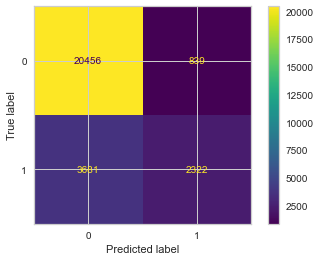

In [64]:
plot_confusion_matrix(model, X_test, y_test, values_format='.0f')

Importance of each variable used in the model:

In [65]:
list(zip(list(X_2.columns), list(model.coef_[0])))

[('humidity9am', 0.022226016248869947),
 ('humidity3pm', 1.2155828731665654),
 ('temp9am', 0.35699563485171987),
 ('rainfall', 0.32276638961820436),
 ('temp3pm', -0.26656427666405147),
 ('precipitation3pm', 0.017384867001950223),
 ('precipitation9am', -0.018486962422454706)]

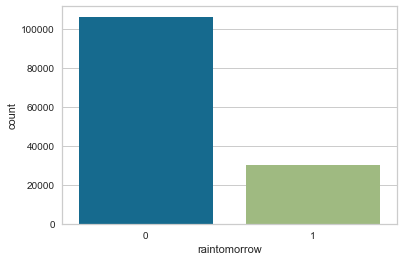

In [66]:
sns.countplot(rain['raintomorrow'],)

We see that our dataset is a little bit unbalanced, we probably will have to deal with recall issues later on

## Conclusion

In [67]:
rain_scores = scores('Baseline 2 (Log. Regression)', baseline2_score, precision2_score, recall2_score)
rain_scores

,Baseline (Log. Regression),Baseline 2 (Log. Regression)
SCORE,0.996190,0.834420
PRECISION,0.991174,0.734578
RECALL,0.991504,0.386807


In [65]:
# Now we have a more realistic model to work on and set as a baseline to compare the other models

# Rain + Wind

In [66]:
# Inserting the wind dataset to see how it affects the overall result:

In [81]:
rain = pd.read_csv('./data/rain_data_aus.csv')
wind = pd.DataFrame()
for i in range(1,9):
    df_aux = pd.read_csv(f'./data/wind_table_0{i}.csv')
    df_aux.columns = ['date', 'location', 'wind_gustdir', 'wind_gustspeed', 'wind_dir9am',
       'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']
    wind = pd.concat([wind,df_aux])
rain_wind =  pd.merge(rain, wind, how='left', on=['date', 'location'])

## Cleaning Dataset

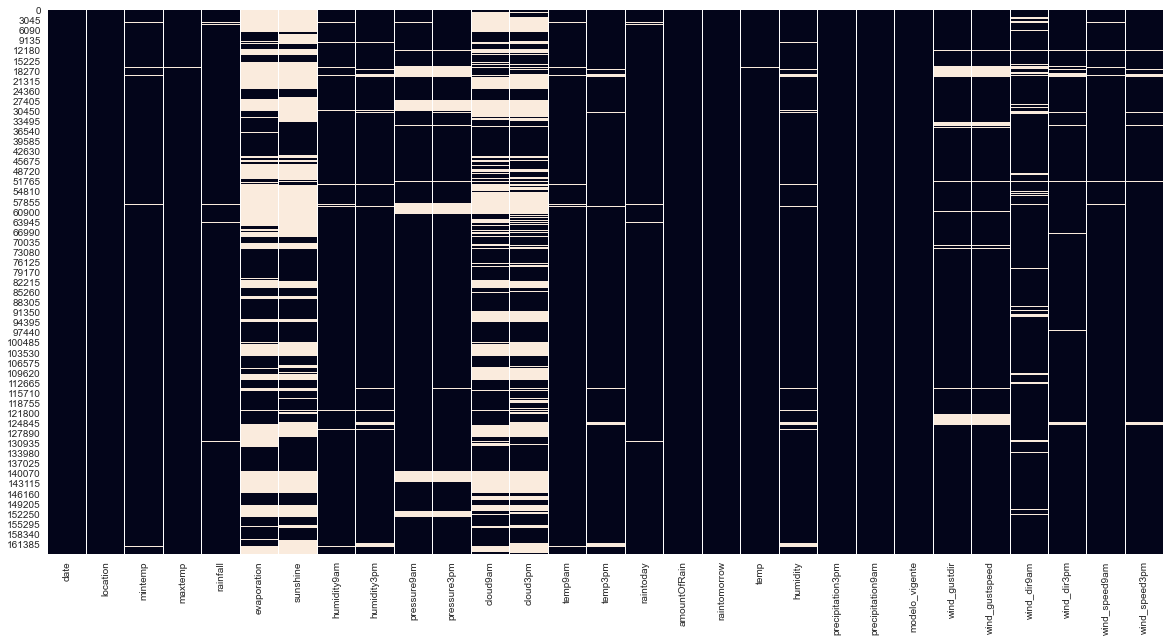

In [82]:
#Heatmap of nulls
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(rain_wind.isnull(), cbar=False);

Checking if there are dupplicated rows

In [83]:
rain_wind.duplicated().sum()

22193

In [84]:
rain_wind.shape

(164386, 29)

Droping duplicated rows

In [85]:
rain_wind.drop_duplicates(inplace=True)

In [86]:
rain_wind.shape

(142193, 29)

### Treating object columns

Transform binary values of 'raintoday' and 'raintomorrow' into 0 and 1

In [87]:
rain_wind['raintoday'] = rain_wind['raintoday'].apply(lambda x: 0 if x == 'No' else 1)

In [88]:
rain_wind['raintomorrow'] = rain_wind['raintomorrow'].apply(lambda x: 0 if x == 'No' else 1)

Drop 'amountOfRain' column, because we won't use it in the model

In [89]:
rain_wind = rain_wind.drop(columns='amountOfRain')

Datetime column:

In [90]:
rain_wind['date'] = pd.to_datetime(rain_wind['date'])

Creating the columns: day, month, year separately

In [91]:
rain_wind['day'] = rain_wind['date'].dt.day
rain_wind['month'] = rain_wind['date'].dt.month
rain_wind['year'] = rain_wind['date'].dt.year

Drop the column 'date', because we don't need it anymore

In [92]:
rain_wind = rain_wind.drop(columns='date')

Get Dummies on the categorical features

In [93]:
rain_wind = pd.concat([rain_wind, pd.get_dummies(rain_wind['wind_dir9am'], prefix='wind_dir9am')], axis=1)

In [94]:
rain_wind = pd.concat([rain_wind, pd.get_dummies(rain_wind['wind_dir3pm'], prefix='wind_dir3pm')], axis=1)

Dropping columns:

In [95]:
rain_wind.head()

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm,day,month,year,wind_dir9am_E,wind_dir9am_ENE,wind_dir9am_ESE,wind_dir9am_N,wind_dir9am_NE,wind_dir9am_NNE,wind_dir9am_NNW,wind_dir9am_NW,wind_dir9am_S,wind_dir9am_SE,wind_dir9am_SSE,wind_dir9am_SSW,wind_dir9am_SW,wind_dir9am_W,wind_dir9am_WNW,wind_dir9am_WSW,wind_dir3pm_E,wind_dir3pm_ENE,wind_dir3pm_ESE,wind_dir3pm_N,wind_dir3pm_NE,wind_dir3pm_NNE,wind_dir3pm_NNW,wind_dir3pm_NW,wind_dir3pm_S,wind_dir3pm_SE,wind_dir3pm_SSE,wind_dir3pm_SSW,wind_dir3pm_SW,wind_dir3pm_W,wind_dir3pm_WNW,wind_dir3pm_WSW
0,Albury,13.4,22.9,0.6,NaN,NaN,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0,0,29.48,28.400000,12,5.115360,0.089825,W,44.0,W,WNW,20.0,24.0,1,12,2008,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Albury,7.4,25.1,0.0,NaN,NaN,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0,0,32.12,2.208569,10,21.497100,0.023477,WNW,44.0,NNW,WSW,4.0,22.0,2,12,2008,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Albury,12.9,25.7,0.0,NaN,NaN,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0,0,32.84,38.000000,17,20.782859,0.027580,WSW,46.0,W,WSW,19.0,26.0,3,12,2008,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Albury,9.2,28.0,0.0,NaN,NaN,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0,0,35.60,21.200000,8,12.028646,0.023962,NE,24.0,SE,E,11.0,9.0,4,12,2008,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Albury,17.5,32.3,1.0,NaN,NaN,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,40.76,41.600000,9,11.883546,0.220164,W,41.0,ENE,NW,7.0,20.0,5,12,2008,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


## Choosing relevant features 

### Preventing data leakage

In [96]:
# Removing features that wouldn't be available at the same day

In [97]:
rain_wind = rain_wind.drop(columns=['location', 'wind_dir9am', 'wind_dir3pm', 'evaporation', 
                                    'sunshine', 'wind_gustdir','mintemp', 'maxtemp', 
                                    'raintoday', 'temp', 'humidity', 'wind_gustspeed',
                                    'cloud3pm', 'cloud9am'])

In [98]:
rain_wind.shape

(142193, 48)

In [99]:
rain_wind = rain_wind.dropna()

In [100]:
rain_wind.shape

(124105, 48)

## Running Logistic Regression

In [101]:
logistic = LogisticRegression(n_jobs=-1)

In [102]:
rain_wind.head()

,rainfall,humidity9am,humidity3pm,pressure9am,pressure3pm,temp9am,temp3pm,raintomorrow,precipitation3pm,precipitation9am,modelo_vigente,wind_speed9am,wind_speed3pm,day,month,year,wind_dir9am_E,wind_dir9am_ENE,wind_dir9am_ESE,wind_dir9am_N,wind_dir9am_NE,wind_dir9am_NNE,wind_dir9am_NNW,wind_dir9am_NW,wind_dir9am_S,wind_dir9am_SE,wind_dir9am_SSE,wind_dir9am_SSW,wind_dir9am_SW,wind_dir9am_W,wind_dir9am_WNW,wind_dir9am_WSW,wind_dir3pm_E,wind_dir3pm_ENE,wind_dir3pm_ESE,wind_dir3pm_N,wind_dir3pm_NE,wind_dir3pm_NNE,wind_dir3pm_NNW,wind_dir3pm_NW,wind_dir3pm_S,wind_dir3pm_SE,wind_dir3pm_SSE,wind_dir3pm_SSW,wind_dir3pm_SW,wind_dir3pm_W,wind_dir3pm_WNW,wind_dir3pm_WSW
0,0.6,71.0,22.0,1007.7,1007.1,16.9,21.8,0,12,5.115360,0.089825,20.0,24.0,1,12,2008,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.0,44.0,25.0,1010.6,1007.8,17.2,24.3,0,10,21.497100,0.023477,4.0,22.0,2,12,2008,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.0,38.0,30.0,1007.6,1008.7,21.0,23.2,0,17,20.782859,0.027580,19.0,26.0,3,12,2008,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.0,45.0,16.0,1017.6,1012.8,18.1,26.5,0,8,12.028646,0.023962,11.0,9.0,4,12,2008,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,82.0,33.0,1010.8,1006.0,17.8,29.7,0,9,11.883546,0.220164,7.0,20.0,5,12,2008,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [103]:
y = rain_wind['raintomorrow']
X = rain_wind.loc[:, (rain_wind.columns!='raintomorrow') & (rain_wind.columns!='modelo_vigente')]

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify=y)

In [105]:
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [106]:
logistic.score(X_train, y_train)

0.839853349985899

In [107]:
wind_score = logistic.score(X_test, y_test)
wind_score

0.8365899842874985

In [108]:
wind_precision = precision_score(y_test, logistic.predict(X_test))
wind_precision

0.71484375

In [109]:
wind_recall = recall_score(y_test, logistic.predict(X_test))
wind_recall

0.43364928909952605

## Conclusion

In [113]:
rain_scores = scores('Model 3 + Wind (Log. Regression)', wind_score, wind_precision, wind_recall)
rain_scores

,Baseline (Log. Regression),Baseline 2 (Log. Regression),Model 3 + Wind (Log. Regression)
SCORE,0.996190,0.834420,0.836590
PRECISION,0.991174,0.734578,0.714844
RECALL,0.991504,0.386807,0.433649


#  Decision Tree

In [111]:
# Studying the features behaviours through tree models

In [143]:
y=rain_wind['raintomorrow']
X=rain_wind.drop(columns=['raintomorrow', 'modelo_vigente'])

In [144]:
# Spliting into Train vs. Test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify=y)

In [145]:
model = DecisionTreeClassifier(max_depth=5,ccp_alpha=0.001,random_state=42)

In [146]:
from sklearn.model_selection import cross_val_score, KFold
results = cross_val_score(model, X_train, y_train, cv=KFold(3, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8144597864854743, 0.005480163467645383)

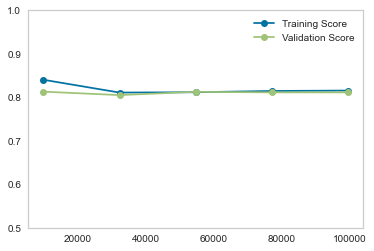

In [118]:
from sklearn.model_selection import learning_curve
curves = learning_curve(model, X, y, scoring='roc_auc')

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis=1),'-o', label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o', label='Validation Score');
plt.ylim([0.5, 1])
plt.legend()
plt.grid()

In [124]:
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [125]:
score = model.score(X_test,y_test)

In [128]:
score_recall = recall_score(y_test, model.predict(X_test))
score_recall

0.469376594969012

In [131]:
precision_recall = precision_score(y_test, model.predict(X_test))
precision_recall

0.6776315789473685

## Conclusion

In [134]:
rain_scores = scores('Model 4 - Decision Tree', score, precision_recall, score_recall)
rain_scores

,Baseline (Log. Regression),Baseline 2 (Log. Regression),Model 3 + Wind (Log. Regression),Model 4 - Decision Tree
SCORE,0.996190,0.834420,0.836590,0.833367
PRECISION,0.991174,0.734578,0.714844,0.677632
RECALL,0.991504,0.386807,0.433649,0.469377


Feature importances:

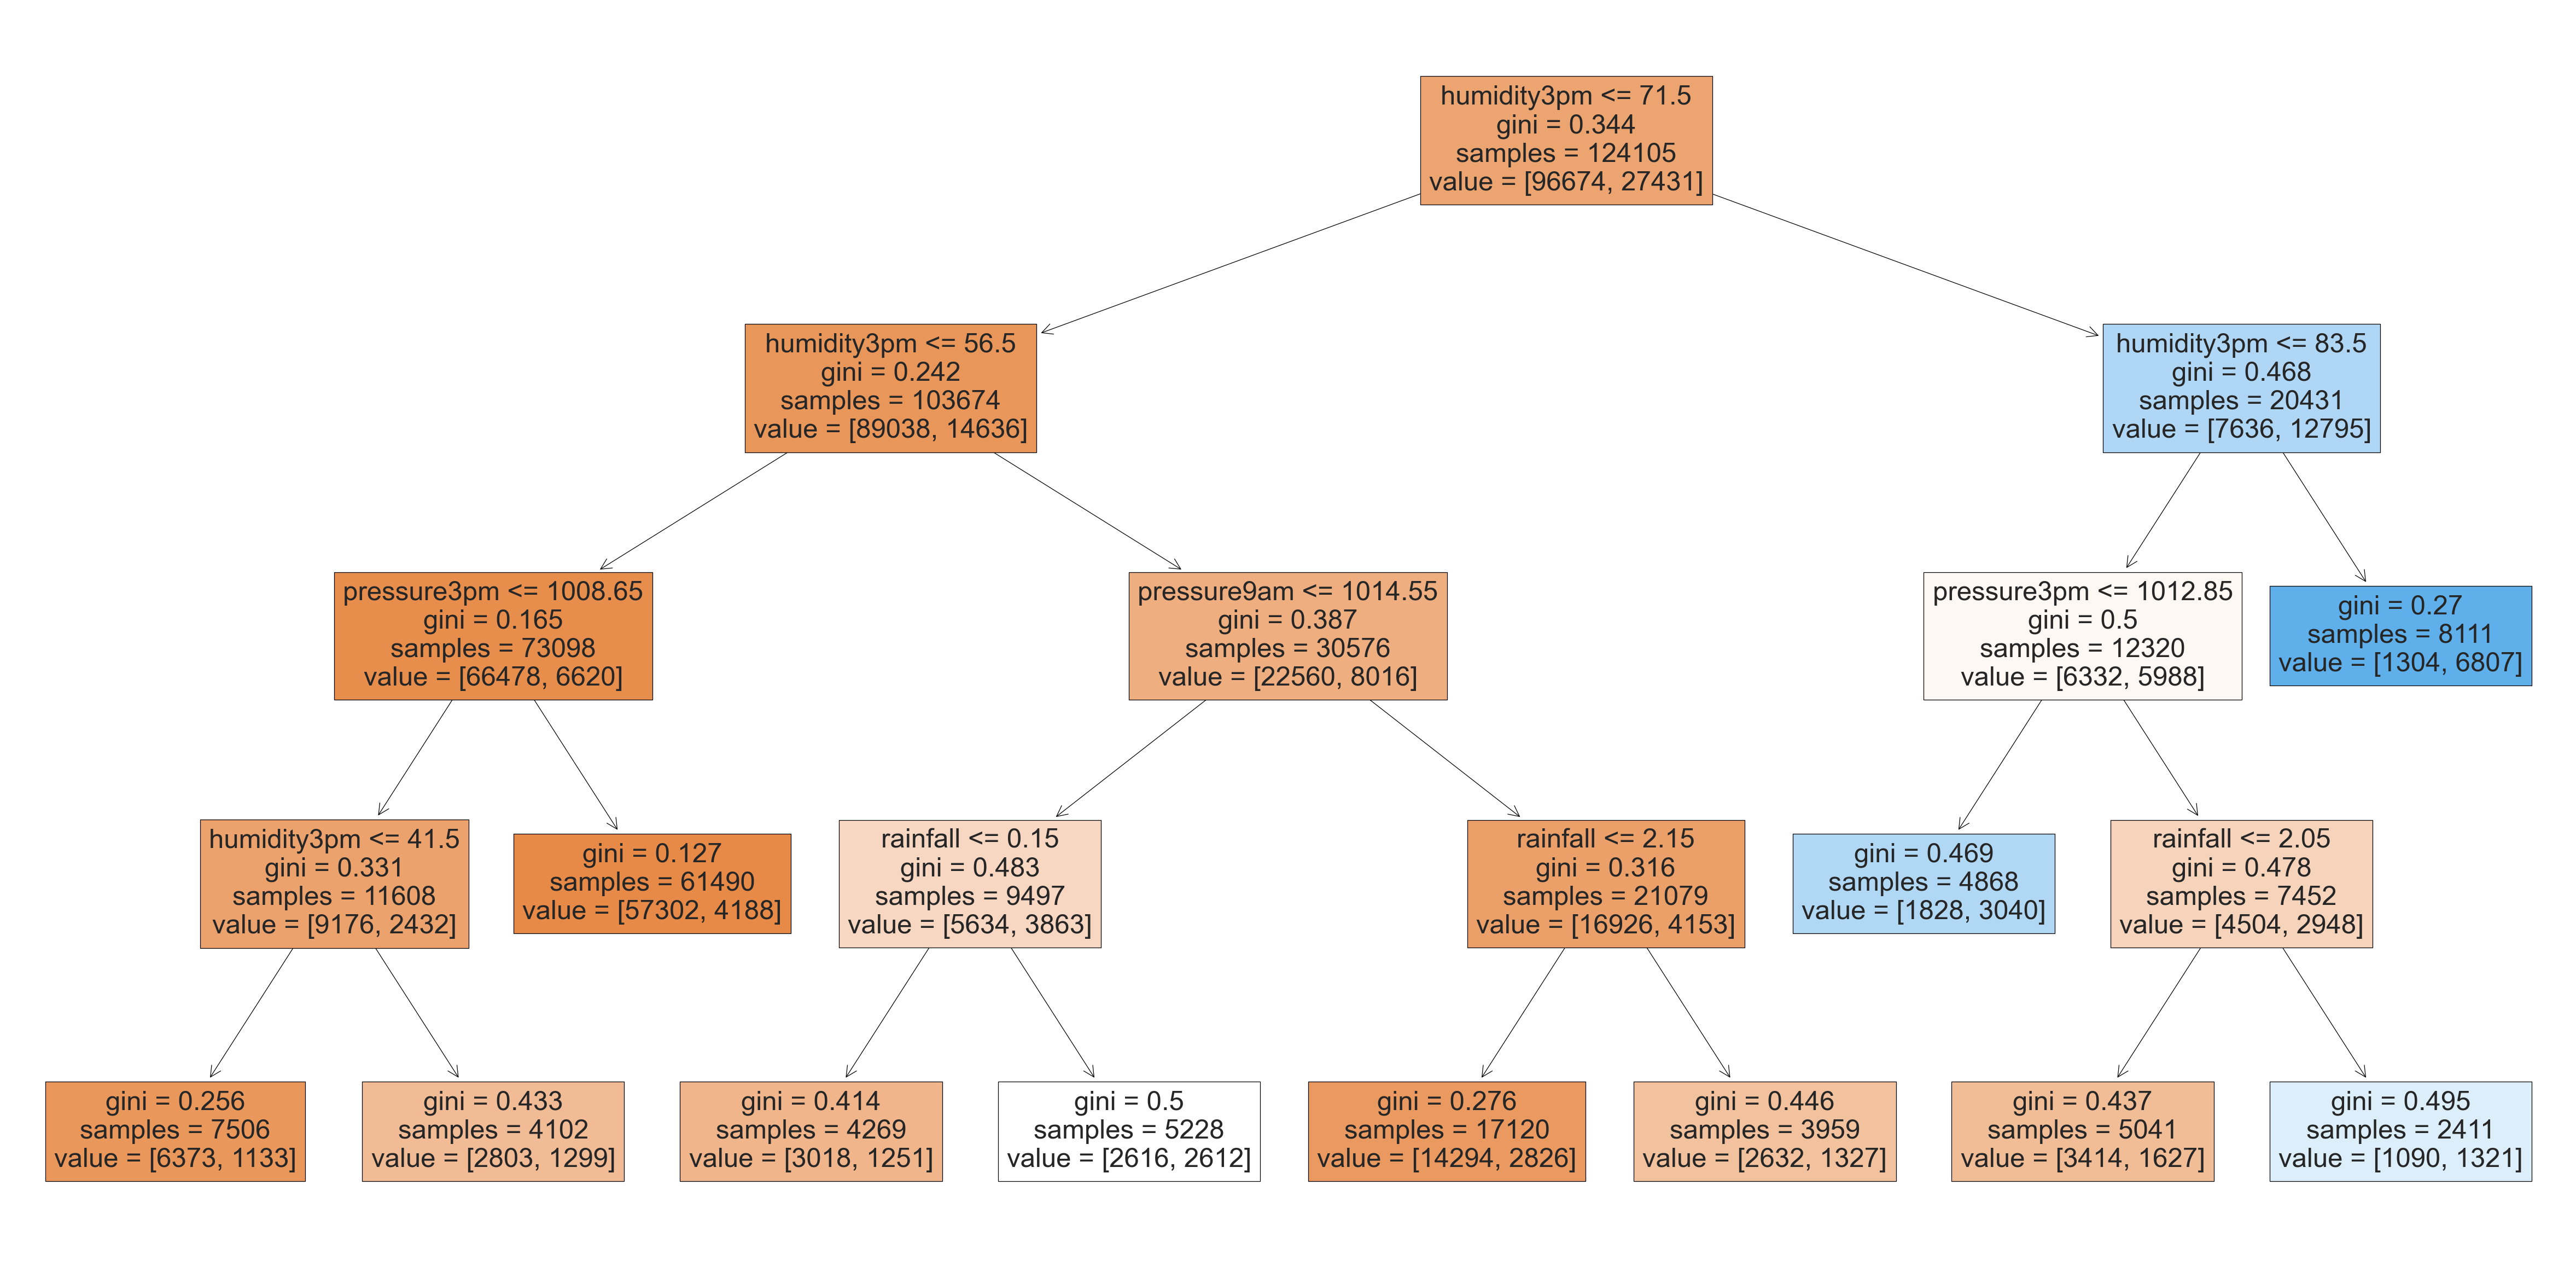

In [124]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,
                         figsize = (20,10), dpi=300)
plot_tree(model, filled=True,feature_names=X.columns);

# Random Forest

In [147]:
y = rain_wind['raintomorrow']
X = rain_wind.loc[:, (rain_wind.columns!='raintomorrow') & (rain_wind.columns!='modelo_vigente')]

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify=y)

In [149]:
forest = RandomForestClassifier(max_depth=5, n_estimators=200, n_jobs=-1)

In [150]:
from sklearn.model_selection import cross_val_score, KFold
results = cross_val_score(forest, X_train, y_train, cv=KFold(3, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8394212779729123, 0.002225067724361416)

In [151]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [152]:
wind_score = forest.score(X_test, y_test)
wind_score

0.8293783489786875

In [153]:
score_recall = recall_score(y_test, forest.predict(X_test))
score_recall

0.2872767043383157

In [154]:
score_precision = precision_score(y_test, forest.predict(X_test))
score_precision

0.8290373487638085

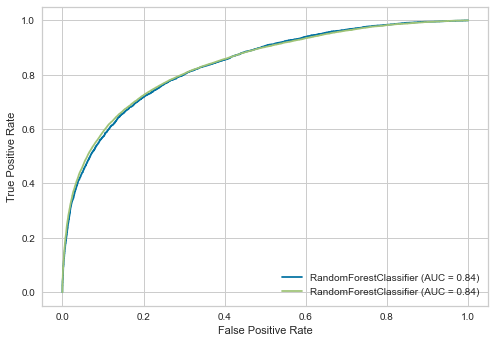

In [137]:
fig, ax = plt.subplots()

plot_roc_curve(forest, X_test, y_test, ax=ax)
plot_roc_curve(forest, X_train, y_train, ax=ax)

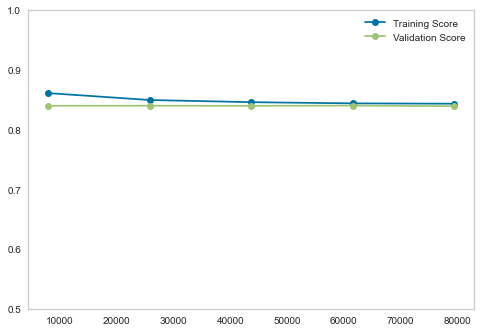

In [138]:
from sklearn.model_selection import learning_curve
curves = learning_curve(forest, X_train, y_train, scoring='roc_auc')

train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis=1),'-o', label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o', label='Validation Score');
plt.ylim([0.5, 1])
plt.legend()
plt.grid()

## Conclusion

The logistic regression still seems to be the best option in terms of 'RECALL' scores

In [155]:
rain_scores = scores('Model 5 - Random Forest', wind_score, score_precision, score_recall)
rain_scores

,Baseline (Log. Regression),Baseline 2 (Log. Regression),Model 3 + Wind (Log. Regression),Model 4 - Decision Tree,Model 5 - Random Forest
SCORE,0.996190,0.834420,0.836590,0.833367,0.829378
PRECISION,0.991174,0.734578,0.714844,0.677632,0.829037
RECALL,0.991504,0.386807,0.433649,0.469377,0.287277


Unlike the result from the Decision Tree model, this time, other features also showed some importance

In [156]:
pd.DataFrame(zip(X.columns, forest.feature_importances_)).sort_values(by=1, ascending=False).head(10)

,0,1
2,humidity3pm,0.425722
0,rainfall,0.200376
1,humidity9am,0.099710
3,pressure9am,0.089775
4,pressure3pm,0.072944
6,temp3pm,0.049382
10,wind_speed3pm,0.015462
5,temp9am,0.013075
9,wind_speed9am,0.010277
17,wind_dir9am_N,0.005631


# XGBoost

In [157]:
xgb = XGBClassifier(max_depth=1, 
                    n_estimators=50, 
                    colsample_bytree=0.7, 
                    n_jobs=-1,
                    stratify=y)

In [158]:
results = cross_val_score(xgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8495754422163084, 0.0035614473982576063)

In [160]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1,
              stratify=0         0
1         0
2         0
3         0
4         0
         ..
164376    0
164378    0
164380    0
164382    0
164384    0
Name: raintomorrow, Length: 124105, dtype: int64,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

In [161]:
wind_score = xgb.score(X_test, y_test)
wind_score

0.8377583497844567

In [162]:
score_recall = recall_score(y_test, xgb.predict(X_test))
score_recall

0.4146919431279621

In [163]:
score_precision = precision_score(y_test, xgb.predict(X_test))
score_precision

0.7360077644775154

## Conclusion

The logistic regression still seems to be the best option in terms of 'RECALL' scores

In [170]:
rain_scores = scores('Model 6 - XGBoost', wind_score, score_precision, score_recall)
rain_scores

,Baseline (Log. Regression),Baseline 2 (Log. Regression),Model 3 + Wind (Log. Regression),Model 4 - Decision Tree,Model 5 - Random Forest,Model 6 - XGBoost
SCORE,0.996190,0.834420,0.836590,0.833367,0.829378,0.837758
PRECISION,0.991174,0.734578,0.714844,0.677632,0.829037,0.736008
RECALL,0.991504,0.386807,0.433649,0.469377,0.287277,0.414692


# KNN Model

In [157]:
from sklearn.neighbors import KNeighborsClassifier

In [158]:
y=rain_wind['raintomorrow']
X=rain_wind.drop(columns=['raintomorrow', 'modelo_vigente'])

In [159]:
knn_75 = KNeighborsClassifier(n_neighbors=75, p=1, n_jobs=-1)

In [160]:
results = cross_val_score(knn_75, X, y, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8619154317471182, 0.00461858787679175)

In [161]:
knn_75.fit(X_train, y_train)
ypred_knn = knn_75.predict(X_test)
ypred_train_knn = knn_75.predict(X_train)
roc_dist_knn = {'test': roc_auc_score(y_test,ypred_knn),'train': roc_auc_score(y_train,ypred_train_knn)}

In [162]:
wind_score=knn_75.score(X,y)
wind_score

0.8479271584545345

In [163]:
score_recall = recall_score(y, knn_75.predict(X))
score_recall

0.42616018373373193

In [164]:
precision_recall = precision_score(y, knn_75.predict(X))
precision_recall

0.7886924841451896

## Conclusion

The logistic regression still seems to be the best option in terms of 'RECALL' scores

In [165]:
rain_scores = scores('Model 7 - KNN', wind_score, score_precision, score_recall)
rain_scores

,Baseline (Log. Regression),Baseline 2 (Log. Regression),Model 3 + Wind Speed (Log. Regression),Model 4 + Wind Speed (Log. Regression),Model 5 - Decision Tree,Model 6 - Random Forest,Model 7 - XGBoost,Model 8 - KNN
SCORE,0.995824,0.834420,0.829569,0.836429,0.834938,0.823899,0.838645,0.847927
PRECISION,0.990995,0.734578,0.716671,0.712709,0.725666,0.831254,0.737568,0.737568
RECALL,0.990005,0.386807,0.400000,0.435472,0.407131,0.255013,0.419067,0.426160


# LightGBM

In [177]:
y=rain_wind['raintomorrow']
X=rain_wind.drop(columns=['raintomorrow', 'modelo_vigente'])

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify=y)

In [179]:
lgb = LGBMClassifier(max_depth=1, n_estimators=100, colsample_bytree=.7, n_jobs=-1)

In [180]:
results = cross_val_score(lgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8478349029314541, 0.0031615221383966136)

Feature importances:

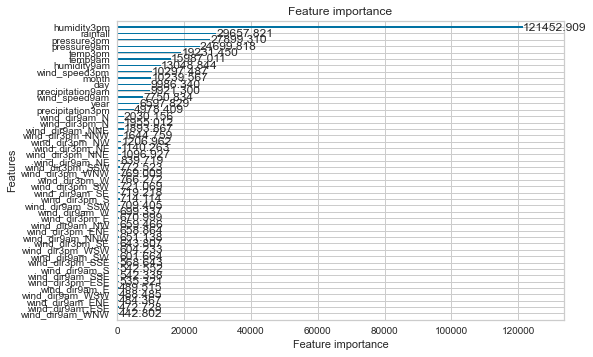

In [200]:
plot_importance(lgb, importance_type='gain')

## Tunning Parameters

### Leaf-wise

num_leaves. This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. However, this simple conversion is not good in practice. The reason is that a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.

min_data_in_leaf. This is a very important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.

max_depth. You also can use max_depth to limit the tree depth explicitly.

In [196]:
lgb = LGBMClassifier(max_depth=5, num_leaves=32, min_data_in_leaf=6, n_estimators=1500, colsample_bytree=.7, n_jobs=-1)

In [197]:
results = cross_val_score(lgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8783071995248362, 0.004244270343565193)

### For fast speed

In [183]:
lgb = LGBMClassifier(max_depth=5, num_leaves=32, min_data_in_leaf=6, n_estimators=1000, 
                     bagging_fraction=1, bagging_freq=3, feature_fraction=1,
                     max_bin=10,
                     colsample_bytree=.7, n_jobs=-1)

In [184]:
results = cross_val_score(lgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8754383862303564, 0.00478423880476924)

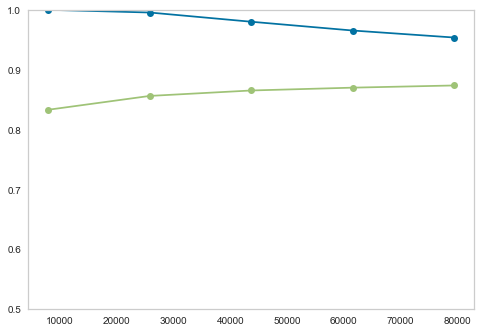

In [185]:
curves = learning_curve(lgb, X_train, y_train, scoring='roc_auc')
train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis=1),'-o')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o');
plt.ylim([0.5, 1])
plt.grid()

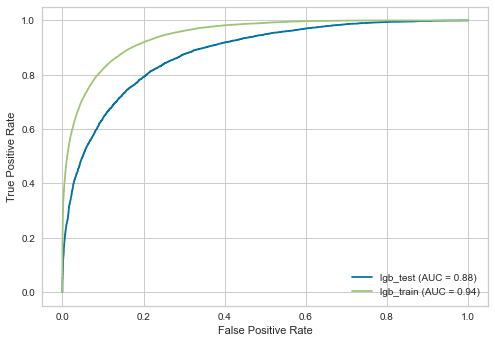

In [186]:
fig, ax = plt.subplots()
lgb.fit(X_train, y_train)
plot_roc_curve(lgb, X_test, y_test, ax=ax, name = 'lgb_test')
plot_roc_curve(lgb, X_train, y_train, ax=ax, name = 'lgb_train')

In [187]:
score=lgb.score(X,y)
score

0.8862414890616817

In [188]:
score_recall = recall_score(y, lgb.predict(X))
score_recall

0.6120812219751376

In [190]:
score_precision = precision_score(y, lgb.predict(X))
score_precision

0.8284403217052351

## Conclusion

The LightGBM seems to be the best model

In [191]:
rain_scores = scores('Model 8 - LGBM', score, score_precision, score_recall)
rain_scores

,Baseline (Log. Regression),Baseline 2 (Log. Regression),Model 3 + Wind Speed (Log. Regression),Model 4 + Wind Speed (Log. Regression),Model 5 - Decision Tree,Model 6 - Random Forest,Model 7 - XGBoost,Model 8 - KNN,Model 9 - LGBM
SCORE,0.995824,0.834420,0.829569,0.836429,0.834938,0.823899,0.838645,0.847927,0.886241
PRECISION,0.990995,0.734578,0.716671,0.712709,0.725666,0.831254,0.737568,0.737568,0.828440
RECALL,0.990005,0.386807,0.400000,0.435472,0.407131,0.255013,0.419067,0.426160,0.612081


# Selecting features for better Results

Analyzing the resulting scores of all models (almost the same), we decided to change the input and evaluate the impact

In [209]:
r = pd.read_csv('./data/rain_data_aus.csv')

In [210]:
# adding wind 
w = pd.DataFrame()
for i in range(1,9):
    df_aux = pd.read_csv(f'./data/wind_table_0{i}.csv')
    df_aux.columns = ['date', 'location', 'wind_gustdir', 'wind_gustspeed', 'wind_dir9am',
       'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']
    w = pd.concat([w,df_aux])
r_w =  pd.merge(r, w, how='left', on=['date', 'location'])

# Converting Location into Long / Lat

In [211]:
from opencage.geocoder import OpenCageGeocode

key = '46b48d2d3d8f4acb88f582e3a83cbe77'
geocoder = OpenCageGeocode(key)

city_lat = {}
city_lng = {}

for city in r_w['location'].unique():
    query = f'{city}, Australia'
    results = geocoder.geocode(query)
    city_lat[city] =results[0]['geometry']['lat']
    city_lng[city] =results[0]['geometry']['lng']

In [212]:
cities = pd.DataFrame(data=[city_lat,city_lng]).T
cities = cities.reset_index()
cities.columns= ['location','lat','lng']
rw = pd.merge(left=r_w,
                    right=cities,
                    on='location')

In [213]:
rw.head(2)

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,amountOfRain,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm,lat,lng
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No,29.48,28.400000,12,5.11536,0.089825,W,44.0,W,WNW,20.0,24.0,-36.080477,146.91628
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No,32.12,2.208569,10,21.49710,0.023477,WNW,44.0,NNW,WSW,4.0,22.0,-36.080477,146.91628


In [214]:
rw.shape

(164386, 31)

## Choosing relevant features 

### Preventing data leakage

In [215]:
# Removing features that wouldn't be available at the same day

In [216]:
rw = rw.drop(['mintemp','maxtemp','temp','humidity','evaporation','sunshine','cloud9am','cloud3pm', 
              'raintoday','amountOfRain', 'wind_gustdir','wind_gustspeed'], axis=1)

## Analyzing relevance by correlation

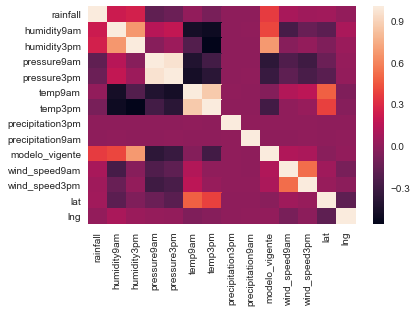

In [217]:
sns.heatmap(rw.corr())

In [218]:
# Based on correlation, all 9am features and precipitation won't be used

In [219]:
rw=rw.drop(columns=['humidity9am','pressure9am', 'temp9am','precipitation3pm', 'precipitation9am', 
                 'wind_speed9am','wind_dir9am'])

In [220]:
rw.head()

,date,location,rainfall,humidity3pm,pressure3pm,temp3pm,raintomorrow,modelo_vigente,wind_dir3pm,wind_speed3pm,lat,lng
0,2008-12-01,Albury,0.6,22.0,1007.1,21.8,No,0.089825,WNW,24.0,-36.080477,146.91628
1,2008-12-02,Albury,0.0,25.0,1007.8,24.3,No,0.023477,WSW,22.0,-36.080477,146.91628
2,2008-12-03,Albury,0.0,30.0,1008.7,23.2,No,0.027580,WSW,26.0,-36.080477,146.91628
3,2008-12-04,Albury,0.0,16.0,1012.8,26.5,No,0.023962,E,9.0,-36.080477,146.91628
4,2008-12-05,Albury,1.0,33.0,1006.0,29.7,No,0.220164,NW,20.0,-36.080477,146.91628


In [221]:
rw.shape

(164386, 12)

## Treating Missing values

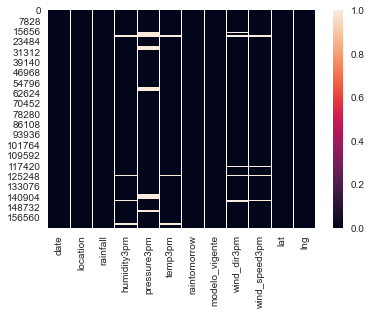

In [222]:
sns.heatmap(rw.isna())

In [223]:
rw = rw.dropna()
rw.shape

(142521, 12)

## Treating object columns

In [224]:
rw.raintomorrow = rw.raintomorrow.apply(lambda x: 0 if x=='No' else 1)

Transforming date into a numerical variable (days in a year and month):

In [225]:
rw.date = pd.to_datetime(rw.date)

In [226]:
rw['day']=rw.date.apply(lambda x: int(x.strftime('%j')))

In [227]:
rw['month']= rw.date.dt.month

In [228]:
rw.head()

,date,location,rainfall,humidity3pm,pressure3pm,temp3pm,raintomorrow,modelo_vigente,wind_dir3pm,wind_speed3pm,lat,lng,day,month
0,2008-12-01,Albury,0.6,22.0,1007.1,21.8,0,0.089825,WNW,24.0,-36.080477,146.91628,336,12
1,2008-12-02,Albury,0.0,25.0,1007.8,24.3,0,0.023477,WSW,22.0,-36.080477,146.91628,337,12
2,2008-12-03,Albury,0.0,30.0,1008.7,23.2,0,0.027580,WSW,26.0,-36.080477,146.91628,338,12
3,2008-12-04,Albury,0.0,16.0,1012.8,26.5,0,0.023962,E,9.0,-36.080477,146.91628,339,12
4,2008-12-05,Albury,1.0,33.0,1006.0,29.7,0,0.220164,NW,20.0,-36.080477,146.91628,340,12


Turning wind direction into dummies

In [229]:
pd.get_dummies(rw.wind_dir3pm, drop_first=True)

,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164381,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
164382,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
164383,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
164384,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [230]:
rw_dummies = pd.concat([rw, pd.get_dummies(rw.wind_dir3pm, drop_first=True)], axis=1)

## Clustering

### First cluster:

In [231]:
from sklearn.preprocessing import StandardScaler
X =rw_dummies.groupby('location')['lat','lng','raintomorrow'].mean()
X_std = StandardScaler().fit_transform(X)

In [232]:
kmeans = KMeans(4)
kmeans.fit(X_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [233]:
X['labels']=kmeans.labels_

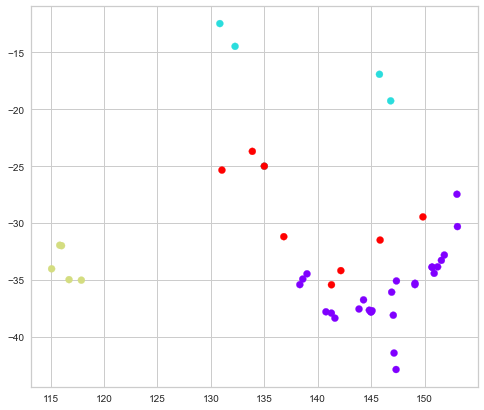

In [234]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(X.lng, X.lat,c=X.labels, cmap='rainbow')

In [235]:
cluster1 = X.drop(columns=['lat','lng','raintomorrow'])

In [236]:
rw_dummies['cluster_1'] = rw_dummies.location.apply(lambda x: cluster1.loc[x,'labels'])

### Second cluster

In [238]:
df = rw_dummies[['date', 'location','lat','raintomorrow','lng']]

In [239]:
df['week']= pd.to_datetime(df['date']).dt.week

C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [240]:
df.drop(columns=['date'],inplace=True)

C:\Users\julia\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [241]:
X= pd.crosstab(index=df['location'],
              columns=df['week'],values=df['raintomorrow'],aggfunc='mean')

In [242]:
X = X.drop(columns=53)

In [243]:
from sklearn.cluster import AgglomerativeClustering
hierarchical = AgglomerativeClustering(n_clusters=3, affinity='correlation', linkage='complete')
hierarchical.fit(X)

AgglomerativeClustering(affinity='correlation', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=3)

In [244]:
X['cluster_3']=hierarchical.labels_

In [245]:
X = pd.merge(X,cities,on='location')

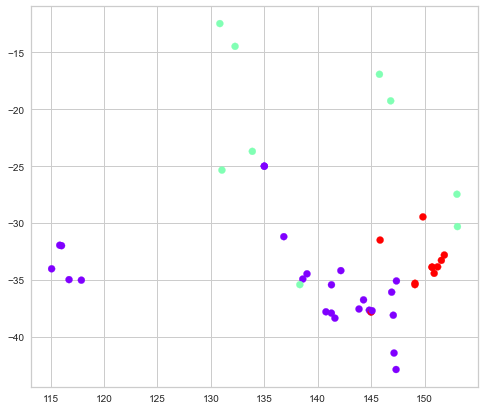

In [246]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(X.lng, X.lat,c=X.cluster_3, cmap='rainbow')

In [247]:
X.reset_index(drop=False, inplace=True)

In [248]:
X_cluster = X[['location','cluster_3']]

In [249]:
rw_dummies = pd.merge(left=rw_dummies,right=X_cluster,on='location')

In [250]:
rw_dummies.to_csv('./data/rw_clean.csv')

### Testing if clustering improves score

In [267]:
rw = pd.read_csv('./data/rw_clean.csv', index_col=0)
rw=rw.drop(columns=['date','wind_dir3pm','modelo_vigente','location', 'cluster_1', 'cluster_3'])
y = rw.raintomorrow
X = rw.drop('raintomorrow', axis=1)
lgb = LGBMClassifier(max_depth=5, num_leaves=32, min_data_in_leaf=6, 
             learning_rate=0.001, n_estimators=1000, 
             bagging_fraction=1, bagging_freq=2, feature_fraction=1,
             max_bin=5,
             colsample_bytree=.7, n_jobs=-1)
results = cross_val_score(lgb, X, y, cv=KFold(4, shuffle=True), scoring='accuracy')
lgbm_nocluster=np.mean(results)


## Running 3 models to dataset - 4 clusters

In [268]:
from lightgbm import LGBMClassifier
rw = pd.read_csv('./data/rw_clean.csv', index_col=0)
rw=rw.drop(columns=['date','wind_dir3pm','modelo_vigente','location'])
df_aux=[]
lgbm={}
for x in [1,3]:
    for i in range(0,rw[f'cluster_{x}'].unique().max()+1):
        df_aux =rw[(rw[f'cluster_{x}'] == i)]
        df_aux = df_aux.drop(['lat', 'lng', 'cluster_1', 'cluster_3'], axis=1)
        y = df_aux.raintomorrow
        X = df_aux.drop('raintomorrow', axis=1)
        lgb = LGBMClassifier(max_depth=5, num_leaves=32, min_data_in_leaf=6, 
                     learning_rate=0.001, n_estimators=1000, 
                     bagging_fraction=1, bagging_freq=2, feature_fraction=1,
                     max_bin=5,
                     colsample_bytree=.7, n_jobs=-1)
        results = cross_val_score(lgb, X, y, cv=KFold(4, shuffle=True), scoring='accuracy')
        name=f'modelo {x} cluster {i}'
        lgbm[name]=(np.mean(results), np.std(results))
        

## Conclusion

- Creating clusters enhanced our model, showing that different models for each cluster will bring better results

- Among all models, the Light GBM was the one that brought the best result


Without clustering:

In [269]:
lgbm_nocluster

0.824797752917761

With clustering:

In [270]:
pd.DataFrame(lgbm).T[0].mean()

0.831970510502921

# Deploy